<a href="https://colab.research.google.com/github/Kshitij04Poojary/Analysis-Of-Covid-19/blob/main/Analysis_Of_Covid_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import torchvision
import numpy as np
import shutil
import random
import torch
import os

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 2.2.1+cu121


CREATING A CUSTOM DATASET

In [3]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]#listdir returns the names of all files and subdirectories
            print(f'Found {len(images)} {class_name} examples')
            return images

        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']

        for c in self.class_names:
            self.images[c] = get_images(c)

        self.image_dirs = image_dirs
        self.transform = transform

    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_names])

    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index%len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

IMAGE TRANSFORMATIONS

In [4]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (224, 224)),#resizes the image to a square of size 224x224 pixels
    torchvision.transforms.RandomHorizontalFlip(),#Randomly flips the image horizontally with a probability of 0.5
    torchvision.transforms.ToTensor(), #Converts the image to a PyTorch tensor
    torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

In [5]:
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

PREPARE DATALOADER

In [6]:
train_dirs = {
    'normal': '/content/drive/My Drive/Covid-19/COVID-19 Radiography Database/normal',
    'viral': '/content/drive/My Drive/Covid-19/COVID-19 Radiography Database/viral',
    'covid': '/content/drive/My Drive/Covid-19/COVID-19 Radiography Database/covid'
}

In [7]:
train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 1311 normal examples
Found 1315 viral examples
Found 189 covid examples


In [8]:
test_dirs = {
    'normal': '/content/drive/My Drive/Covid-19/COVID-19 Radiography Database/test/normal',
    'viral': '/content/drive/My Drive/Covid-19/COVID-19 Radiography Database/test/viral',
    'covid': '/content/drive/My Drive/Covid-19/COVID-19 Radiography Database/test/covid'
}

In [9]:
test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 30 normal examples
Found 30 viral examples
Found 30 covid examples


In [10]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

print('Number of training batches:', len(dl_train))
print('Number of test batches:', len(dl_test))

Number of training batches: 470
Number of test batches: 15


DATA VISUALIZATION

In [11]:
class_names = train_dataset.class_names

def show_images(images, labels, preds):
    plt.figure(figsize=(16, 9))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks = [], yticks = [])
        image = image.numpy().transpose((1, 2, 0))#The original format might be (channels, height, width), and this line transposes it to (height, width, channels).
        mean  = np.array([0.485, 0.456, 0.406])
        std   = np.array([0.229, 0.224, 0.225])
        image = image*std + mean
        image = np.clip(image, 0., 1.)#ensures that all values in the image array are between 0 and 1 (inclusive).
        plt.imshow(image)
        col   = 'green'
        if preds[i] != labels[i]:
            col = 'red'

        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color = col)
    plt.tight_layout()
    plt.show()

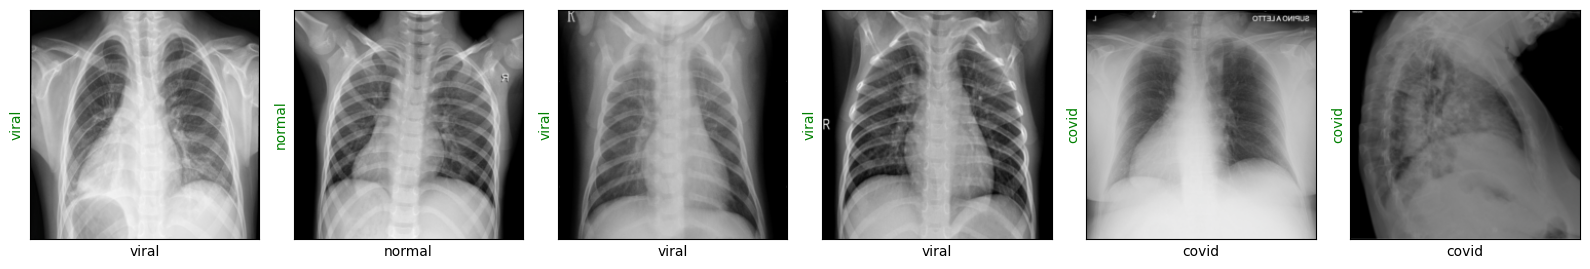

In [14]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

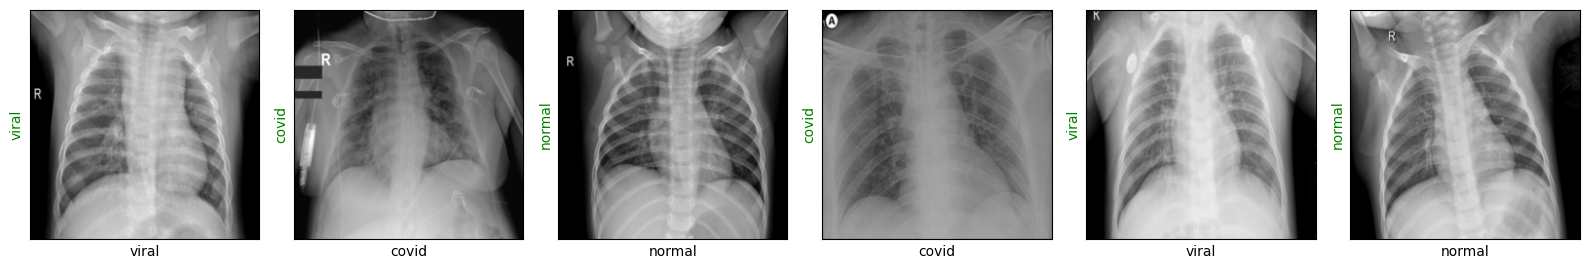

In [13]:
images,labels=next(iter(dl_test))
show_images(images,labels,labels)

CREATING THE MODEL

In [15]:
resnet18=torchvision.models.resnet18(pretrained=True)
print(resnet18)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 79.1MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
resnet18.fc = torch.nn.Linear(in_features = 512, out_features = 3)
loss_fn= torch.nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(resnet18.parameters(), lr = 3e-5)

In [17]:
def show_preds():
  resnet18.eval()
  images,labels=next(iter(dl_test))
  outputs=resnet18(images)
  _,preds=torch.max(outputs,1)
  show_images(images,labels,preds)

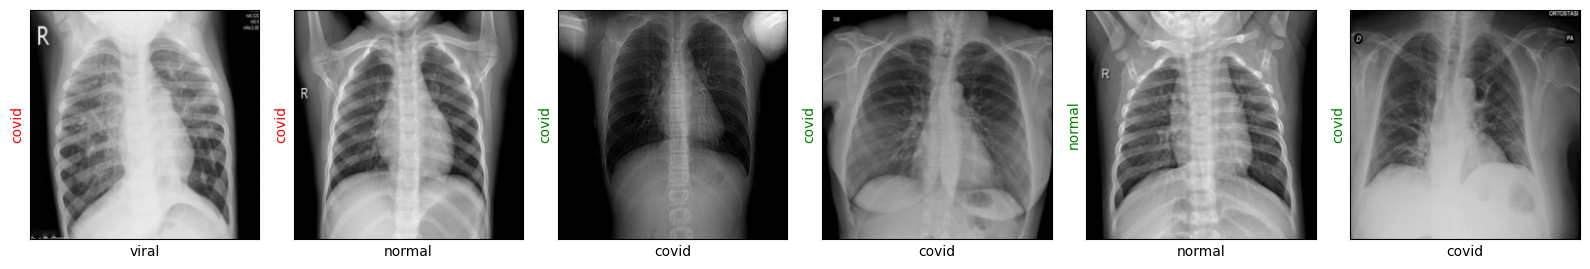

In [19]:
show_preds()

TRAINING THE MODEL

In [20]:
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        resnet18.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()#converts the tensor to a scalar value
            if train_step % 20 == 0:#evaluate the model after every 20 steps
                print('Evaluating at step', train_step)

                accuracy = 0

                resnet18.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())#converts the boolean values into a numpy array

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                show_preds()

                resnet18.train()

                if accuracy >= 0.95:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

Starting training..
Starting epoch 1/1
Evaluating at step 0
Validation Loss: 1.0278, Accuracy: 0.5111


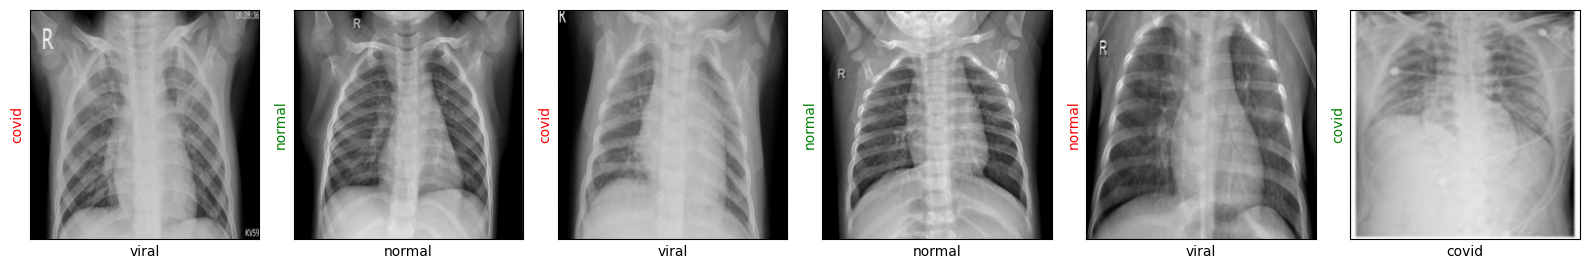

Evaluating at step 20
Validation Loss: 0.7209, Accuracy: 0.7667


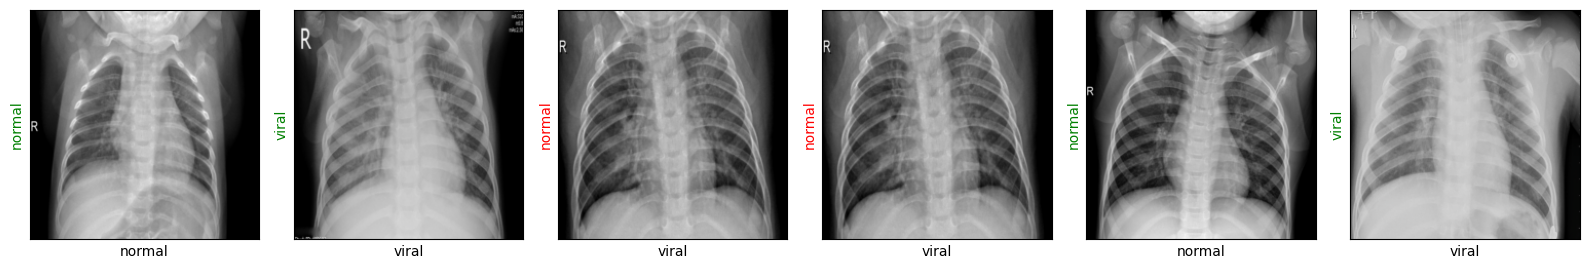

Evaluating at step 40
Validation Loss: 0.3722, Accuracy: 0.9000


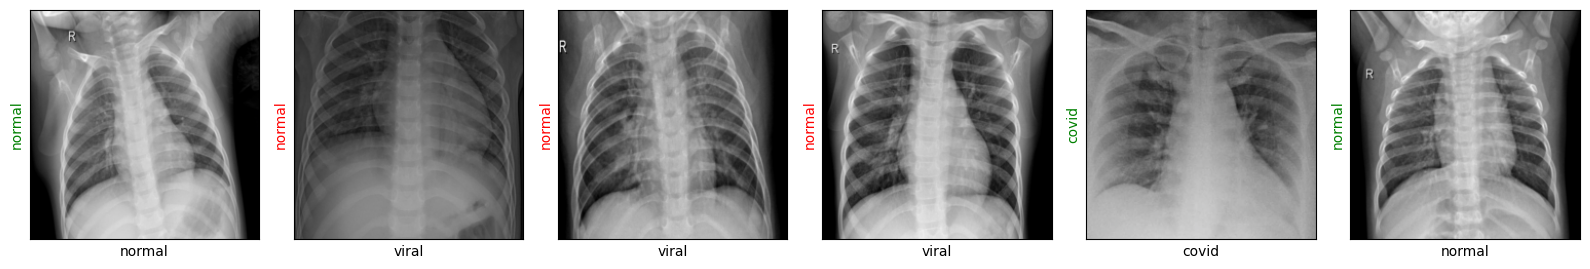

Evaluating at step 60
Validation Loss: 0.4149, Accuracy: 0.8556


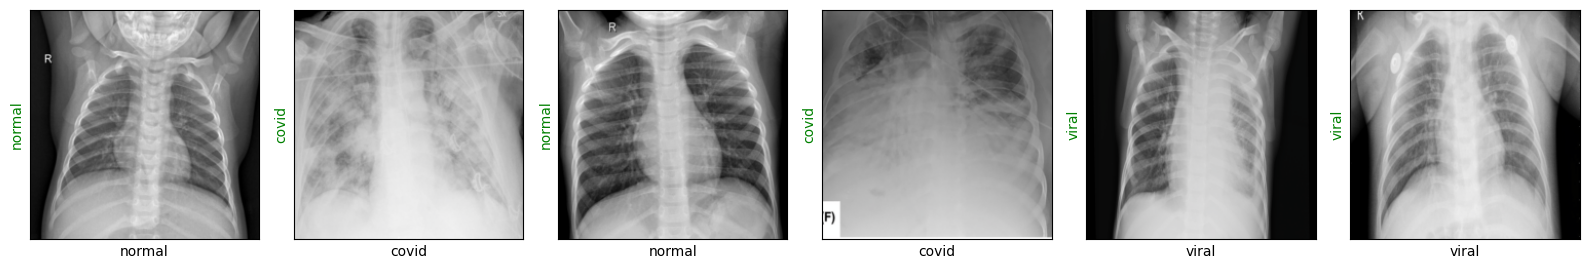

Evaluating at step 80
Validation Loss: 0.2973, Accuracy: 0.9000


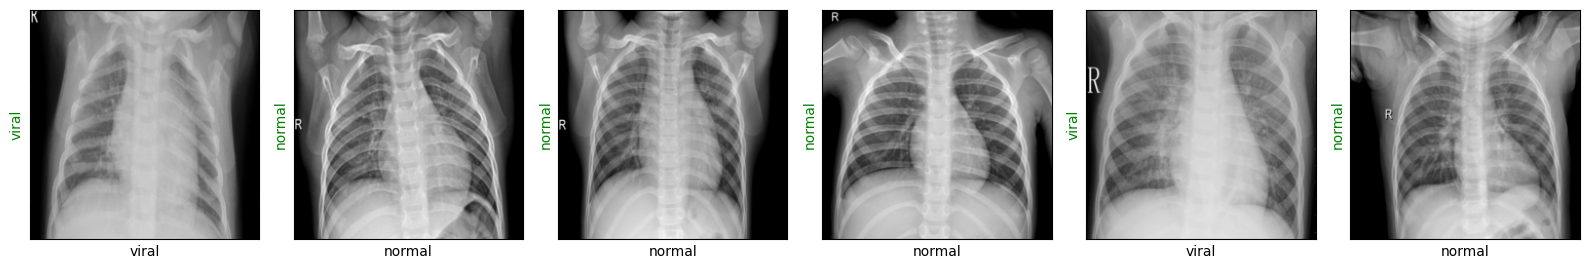

Evaluating at step 100
Validation Loss: 0.2384, Accuracy: 0.9444


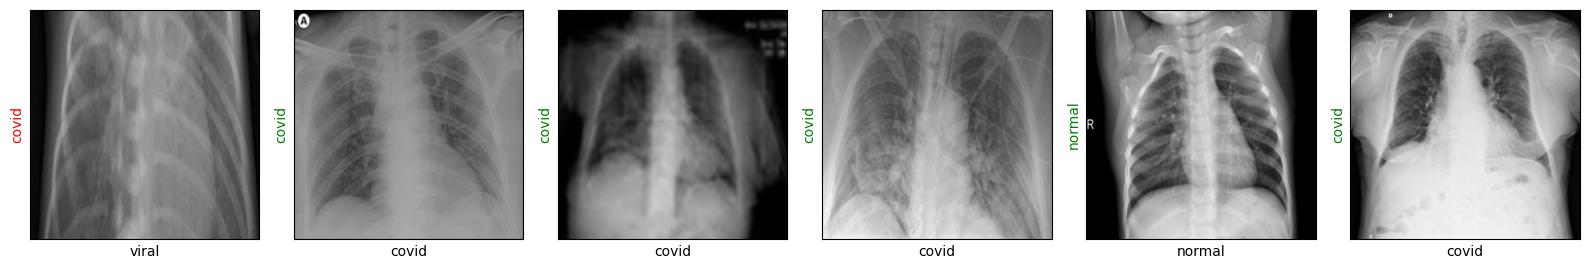

Evaluating at step 120
Validation Loss: 0.1739, Accuracy: 0.9667


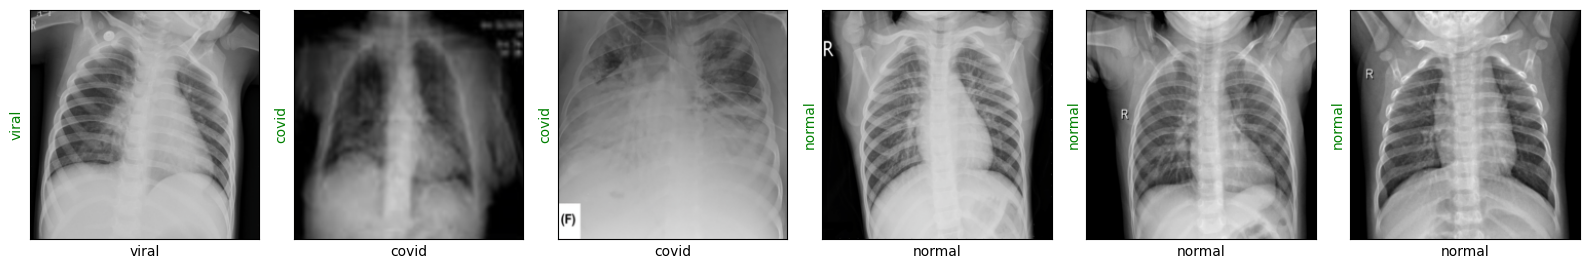

Performance condition satisfied, stopping..


In [21]:
train(epochs=1)

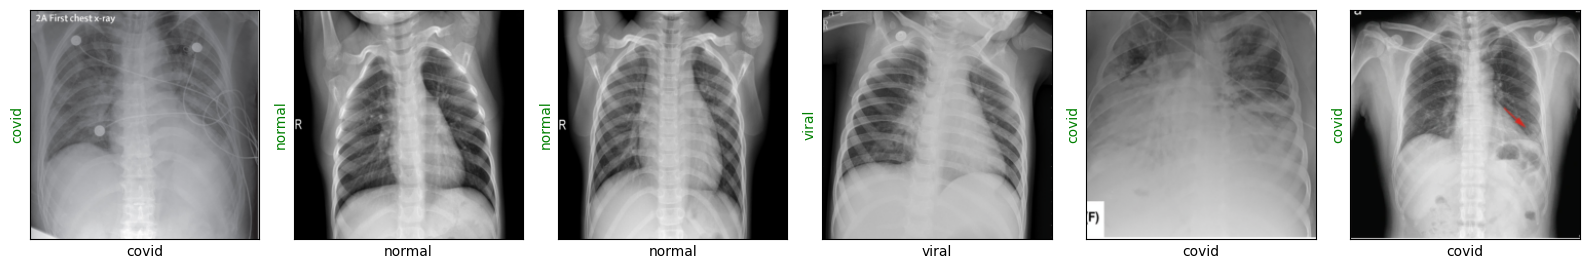

In [22]:
show_preds()